
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.19?urlpath=lab/tree/analysis/1D/extended_source_spectral_analysis.ipynb)
- You may download all the notebooks in the documentation as a
[tar file](../../../_downloads/notebooks-0.19.tar).
- **Source files:**
[extended_source_spectral_analysis.ipynb](../../../_static/notebooks/extended_source_spectral_analysis.ipynb) |
[extended_source_spectral_analysis.py](../../../_static/notebooks/extended_source_spectral_analysis.py)
</div>


# Spectral analysis of extended sources

## Prerequisites:

- Understanding of spectral analysis techniques in classical Cherenkov astronomy.
- Understanding the basic data reduction and modeling/fitting processes with the gammapy library API as shown in the [first gammapy analysis with the gammapy library API tutorial](../../starting/analysis_2.ipynb)

## Context

Many VHE sources in the Galaxy are extended. Studying them with a 1D spectral analysis is more complex than studying point sources. 
One often has to use complex (i.e. non circular) regions and more importantly, one has to take into account the fact that the instrument response is non uniform over the selectred region.
A typical example is given by the supernova remnant RX J1713-3935 which is nearly 1 degree in diameter. See the [following article](https://ui.adsabs.harvard.edu/abs/2018A%26A...612A...6H/abstract).

**Objective: Measure the spectrum of RX J1713-3945 in a 1 degree region fully enclosing it.**

## Proposed approach:

We have seen in the general presentation of the spectrum extraction for point sources, see [the corresponding notebook](spectral_analysis.ipynb), that Gammapy uses specific datasets makers to first produce reduced spectral data and then to extract OFF measurements with reflected background techniques: the `~gammapy.makers.SpectrumDatasetMaker` and the `~gammapy.makers.ReflectedRegionsBackgroundMaker`. However if the flag `use_region_center` is not set to `False`, the former simply computes the reduced IRFs at the center of the ON region (assumed to be circular).

This is no longer valid for extended sources. To be able to compute average responses in the ON region, we can set `use_region_center=False` with the `~gammapy.makers.SpectrumDatasetMaker`, in which case the values of the IRFs are averaged over the entire region.

In summary we have to:

- Define an ON region (a `~regions.SkyRegion`) fully enclosing the source we want to study.
- Define a `~gammapy.maps.RegionGeom` with the ON region and the required energy range (beware in particular, the true energy range).  
- Create the necessary makers : 
    - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker` with `use_region_center=False`
    - the OFF background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Produce a spectrum dataset
    - Extract the OFF data to produce a `~gammapy.datasets.SpectrumDatasetOnOff` and compute a safe range for it.
    - Stack or store the resulting spectrum dataset.
- Finally proceed with model fitting on the dataset as usual.

Here, we will use the RX J1713-3945 observations from the H.E.S.S. first public test data release. The tutorial is implemented with the intermediate level API.

## Setup 

As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)

## Select the data

We first set the datastore and retrieve a few observations from our source.

In [3]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
obs_ids = [20326, 20327, 20349, 20350, 20396, 20397]
# In case you want to use all RX J1713 data in the HESS DR1
# other_ids=[20421, 20422, 20517, 20518, 20519, 20521, 20898, 20899, 20900]

observations = datastore.get_observations(obs_ids)

No HDU found matching: OBS_ID = 20326, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20327, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20349, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20350, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20396, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 20397, HDU_TYPE = rad_max, HDU_CLASS = None


## Prepare the datasets creation

### Select the ON region

Here we take a simple 1 degree circular region because it fits well with the morphology of RX J1713-3945. More complex regions could be used e.g. `~regions.EllipseSkyRegion` or `~regions.RectangleSkyRegion`.

In [4]:
target_position = SkyCoord(347.3, -0.5, unit="deg", frame="galactic")
radius = Angle("0.5 deg")
on_region = CircleSkyRegion(target_position, radius)

### Define the geometries

This part is especially important. 
- We have to define first energy axes. They define the axes of the resulting `~gammapy.datasets.SpectrumDatasetOnOff`. In particular, we have to be careful to the true energy axis: it has to cover a larger range than the reconstructed energy one.
- Then we define the region geometry itself from the on region.

In [5]:
# The binning of the final spectrum is defined here.
energy_axis = MapAxis.from_energy_bounds(0.1, 40.0, 10, unit="TeV")

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, 30, unit="TeV", name="energy_true"
)

geom = RegionGeom(on_region, axes=[energy_axis])

### Create the makers

First we instantiate the target `~gammapy.datasets.SpectrumDataset`.  

In [6]:
dataset_empty = SpectrumDataset.create(
    geom=geom,
    energy_axis_true=energy_axis_true,
)

Now we create its associated maker. Here we need to produce, counts, exposure and edisp (energy dispersion) entries. PSF and IRF background are not needed, therefore we don't compute them.

**IMPORTANT**: Note that `use_region_center` is set to `False`. This is necessary so that the `~gammapy.makers.SpectrumDatasetMaker` considers the whole region in the IRF computation and not only the center.

In [7]:
maker = SpectrumDatasetMaker(
    selection=["counts", "exposure", "edisp"], use_region_center=False
)

Now we create the OFF background maker for the spectra. If we have an exclusion region, we have to pass it here. We also define the safe range maker.

In [8]:
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

## Perform the data reduction loop.

We can now run over selected observations. For each of them, we:
- create the `~gammapy.datasets.SpectrumDataset`
- Compute the OFF via the reflected background method and create a `~gammapy.datasets.SpectrumDatasetOnOff` object
- Run the safe mask maker on it
- Add the `~gammapy.datasets.SpectrumDatasetOnOff` to the list.

In [9]:
%%time
datasets = Datasets()

for obs in observations:
    # A SpectrumDataset is filled in this geometry
    dataset = maker.run(dataset_empty.copy(name=f"obs-{obs.obs_id}"), obs)

    # Define safe mask
    dataset = safe_mask_maker.run(dataset, obs)

    # Compute OFF
    dataset = bkg_maker.run(dataset, obs)

    # Append dataset to the list
    datasets.append(dataset)

CPU times: user 1.92 s, sys: 90.6 ms, total: 2.01 s
Wall time: 2.01 s


In [10]:
datasets.meta_table

NAME,TYPE,TELESCOP,OBS_ID,RA_PNT,DEC_PNT
,,,,deg,deg
str9,str20,str4,int64,float64,float64
obs-20326,SpectrumDatasetOnOff,HESS,20326,259.29852294921875,-39.76222229003906
obs-20327,SpectrumDatasetOnOff,HESS,20327,257.4773254394531,-39.76222229003906
obs-20349,SpectrumDatasetOnOff,HESS,20349,259.29852294921875,-39.76222229003906
obs-20350,SpectrumDatasetOnOff,HESS,20350,257.4773254394531,-39.76222229003906
obs-20396,SpectrumDatasetOnOff,HESS,20396,258.3879089355469,-39.06222152709961
obs-20397,SpectrumDatasetOnOff,HESS,20397,258.3879089355469,-40.462223052978516


## Explore the results
We can peek at the content of the spectrum datasets

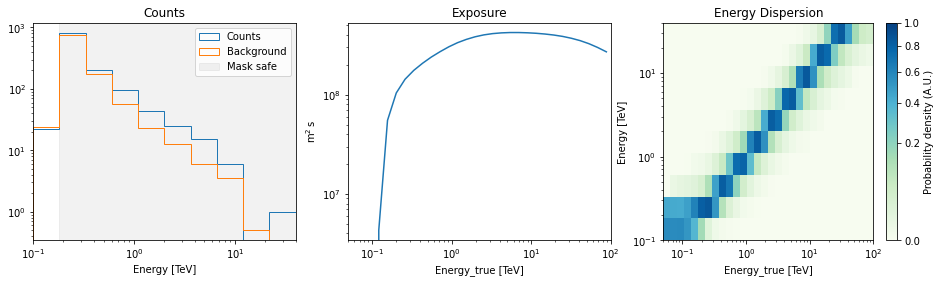

In [11]:
datasets[0].peek();

### Cumulative excess and signficance

Finally, we can look at cumulative significance and number of excesses. This is done with the `info_table` method of `~gammapy.datasets.Datasets`. 

In [12]:
info_table = datasets.info_table(cumulative=True)

In [13]:
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,1216,1045.5,170.5,4.159464335903991,1102.3333333333333,1102.3333333333333,nan,4305864.0,422089504.0,1500.0090848207474,1683.0,0.8106617568555015,0.6969957786121931,0.11366597824330839,10,9,wstat,43.26800161601427,2091,9.0,18.0,0.5
stacked,2339,2068.5,270.5,4.7224642932828935,2158.666666666667,2158.666666666667,nan,14651096.0,831745088.0,2997.0830642580986,3366.0,0.7804254836623952,0.6901710615458163,0.09025442211657883,10,9,wstat,72.2340282463576,4137,9.0,18.0,0.5
stacked,3521,3040.5,480.5,6.880790051412004,3200.6666666666665,3200.6666666666665,nan,25027040.0,1240954624.0,4491.585438072681,5048.0,0.7839102803554472,0.6769324644762106,0.10697781587923669,10,9,wstat,121.08402714166986,6081,9.0,18.0,0.5
stacked,4684,4031.0,653.0,8.11478193157773,4248.666666666668,4248.666666666668,nan,29493964.0,1661560320.0,5989.239929735661,6730.0,0.782069186566505,0.6730403268679722,0.10902885969853283,10,9,wstat,159.53811351626462,8062,9.0,18.0,0.5
stacked,5895,5020.33349609375,874.6665,9.869911438596262,5293.754465997458,5293.754465997458,nan,39191584.0,2070336896.0,7488.24085265398,8413.0,0.7872342938743344,0.6704289558627705,0.11680533801156395,10,9,wstat,214.86274893608885,11030,9.0,19.773586770130027,0.4523509740829468
stacked,6985,5991.83349609375,993.1665,10.251113623835666,6305.481315567763,6305.481315567763,nan,41748740.0,2499471872.0,8993.412164390087,10095.0,0.7766796264111517,0.6662469579475904,0.11043266846356133,10,9,wstat,238.19703760223325,12973,9.0,19.48602211261666,0.45818132162094116


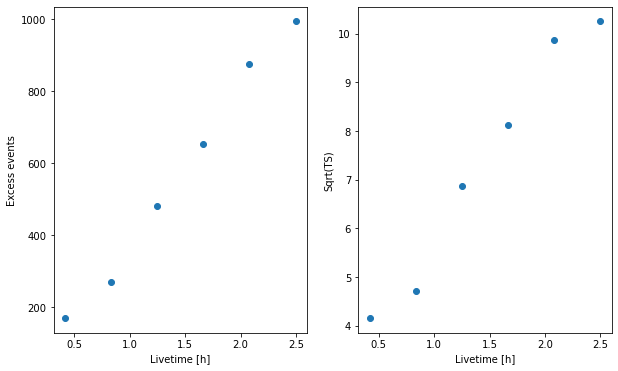

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121)
ax.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

plt.xlabel("Livetime [h]")
plt.ylabel("Excess events")

ax = fig.add_subplot(122)
ax.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

## Perform spectral model fitting

Here we perform a joint fit. 

We first create the model, here a simple powerlaw, and assign it to every dataset in the `~gammapy.datasets.Datasets`.

In [15]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="RXJ 1713")

datasets.models = [model]

Now we can run the fit

In [16]:
fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 38
	total stat : 52.79

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 38
	total stat : 52.79




### Explore the fit results

First the fitted parameters values and their errors.

In [17]:
datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str8,str8,str9,float64,str14,float64,float64,float64,bool,str1
RXJ 1713,spectral,index,2.1102e+00,,6.129e-02,nan,nan,False,
RXJ 1713,spectral,amplitude,1.3576e-11,cm-2 s-1 TeV-1,9.757e-13,nan,nan,False,
RXJ 1713,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


Then plot the fit result to compare measured and expected counts. Rather than plotting them for each individual dataset, we stack all datasets and plot the fit result on the result.

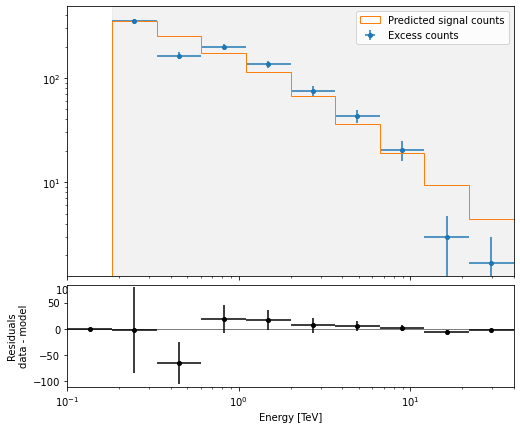

In [18]:
# First stack them all
reduced = datasets.stack_reduce()
# Assign the fitted model
reduced.models = model
# Plot the result

ax_spectrum, ax_residuals = reduced.plot_fit()
reduced.plot_masks(ax=ax_spectrum);